In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from tabulate import tabulate
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import scipy.stats as stats
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt

In [34]:
# Function to create 40 monthly lagged features
def create_monthly_lagged_features(df, num_months=40):
    lagged_data = [df]
    
    for col in df.columns.drop('Date'):
        for i in range(1, num_months + 1):
            lagged_data.append(df[col].shift(i * 20).rename(f'{col}_lag_{i * 20}'))  # 20 days ~ 1 month trading

    df_lagged = pd.concat(lagged_data, axis=1)
    return df_lagged

# Assuming 'df' is your full DataFrame
# Create lagged features on the entire dataset
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')
df['Date'] = pd.to_datetime(df['Date'])
df_lagged = create_monthly_lagged_features(df, num_months=40)

# Drop rows with NaN values due to lagging
df_lagged = df_lagged.dropna()

# Reset index to avoid issues after dropping rows
df_lagged.reset_index(drop=True, inplace=True)

# Split data into train, validation, and test sets based on the given date ranges
end_date = df_lagged['Date'].max()
test_start_date = end_date - pd.DateOffset(months=18)
validation_start_date = end_date - pd.DateOffset(years=3)

train = df_lagged[df_lagged['Date'] < validation_start_date]
validation = df_lagged[(df_lagged['Date'] >= validation_start_date) & (df_lagged['Date'] < test_start_date)]
test = df_lagged[df_lagged['Date'] >= test_start_date]




In [35]:
def encode_cyclical(a, max_value):
    x = (np.sin(2 * np.pi * a) + 1) / max_value
    y = (np.cos(2 * np.pi * a) + 1) / max_value
    return x, y
    
def encode_df(df):
    df['year'] = df['Date'].dt.year # This one is continious and numeric, must be scaled later
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['day_of_week'] = df['Date'].dt.day_of_week
    df['day_of_year'] = df['Date'].dt.day_of_year
    df['is_month_end'] = df['Date'].dt.is_month_end
    df['is_leap_year'] = df['Date'].dt.is_leap_year
    
    # These are numerical, cyclic encoding for them
    df['month_sin'], df['month_cos'] = encode_cyclical(df['month'], 12)
    df['day_sin'], df['day_cos'] = encode_cyclical(df['day'], 31)
    df['day_of_week_sin'], df['day_of_week_cos'] = encode_cyclical(df['day_of_week'], 7)
    df['day_of_year_sin'], df['day_of_year_cos'] = encode_cyclical(df['day_of_year'], 366)
    
    # These ones are categorical, one hot for them
    df = pd.get_dummies(df, columns=['is_month_end', 'is_leap_year']).astype(int)
    
     # kan kanskje flytte denne over til den seksjonen hvor man fjerner features og sånn
    # df = df.drop(columns=['Date', 'month', 'day', 'day_of_week', 'day_of_year'])
    df = df.drop(columns=['month', 'day', 'day_of_week', 'day_of_year'])


    return df
    
train = encode_df(train)
validation = encode_df(validation)
test = encode_df(test)
print(train)


                     Date  Open  High  Low  Close     Volume  OpenInt  \
0     1209600000000000000   120   122  120    122  214976199        0   
1     1209686400000000000   124   124  122    123  208440151        0   
2     1209945600000000000   122   123  122    122  136036845        0   
3     1210032000000000000   121   123  121    123  205862331        0   
4     1210118400000000000   123   123  121    121  228736816        0   
...                   ...   ...   ...  ...    ...        ...      ...   
1638  1414972800000000000   189   190  189    189   99562746        0   
1639  1415059200000000000   189   189  188    189   99162592        0   
1640  1415145600000000000   190   190  189    190   97384757        0   
1641  1415232000000000000   190   191  189    191  113667968        0   
1642  1415318400000000000   191   191  190    191   95183244        0   

      Open_lag_20  Open_lag_40  Open_lag_60  ...  day_sin  day_cos  \
0             118          116          118  ...     

C:\Users\ander\AppData\Local\Temp\ipykernel_14012\2308211626.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['year'] = df['Date'].dt.year # This one is continious and numeric, must be scaled later
C:\Users\ander\AppData\Local\Temp\ipykernel_14012\2308211626.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['Date'].dt.year # This one is continious and numeric, must be scaled later
C:\Users\ander\AppData\Local\Temp\ipykernel_14012\2308211626.py:8: PerformanceWarning: DataFrame is highly fragment

In [36]:

# Apply log transformation
train['Volume'] = np.log1p(train['Volume'])  # log transformer den fordi den var skækk
validation['Volume'] = np.log1p(validation['Volume'])  # log transformer den fordi den var skækk
test['Volume'] = np.log1p(test['Volume'])  # log transformer den fordi den var skækk, samme for alle


In [37]:
features_to_scale = ['Open', 'Close', 'High', 'Low', 'Volume', 'year']
def normalize_numerical_features(df):
    scaler = MinMaxScaler()
    columns_to_scale = [col for col in df.columns if any(feature in col for feature in features_to_scale)]
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
 
normalize_numerical_features(train)
normalize_numerical_features(validation)
normalize_numerical_features(test)

In [32]:
print(test)

                     Date      Open      High       Low     Close    Volume  \
2019  1462838400000000000  0.064516  0.095238  0.107692  0.123077  0.389387   
2020  1462924800000000000  0.080645  0.095238  0.107692  0.092308  0.412314   
2021  1463011200000000000  0.080645  0.079365  0.092308  0.092308  0.450351   
2022  1463097600000000000  0.064516  0.063492  0.076923  0.061538  0.482254   
2023  1463356800000000000  0.032258  0.079365  0.076923  0.092308  0.389212   
...                   ...       ...       ...       ...       ...       ...   
2396  1509926400000000000  1.000000  1.000000  1.000000  0.984615  0.190327   
2397  1510012800000000000  1.000000  1.000000  1.000000  0.984615  0.250842   
2398  1510099200000000000  1.000000  1.000000  1.000000  1.000000  0.196617   
2399  1510185600000000000  0.983871  0.984127  0.969231  0.984615  0.461395   
2400  1510272000000000000  0.983871  0.984127  0.984615  0.984615  0.269784   

      OpenInt  Open_lag_20  Open_lag_40  Open_lag_6

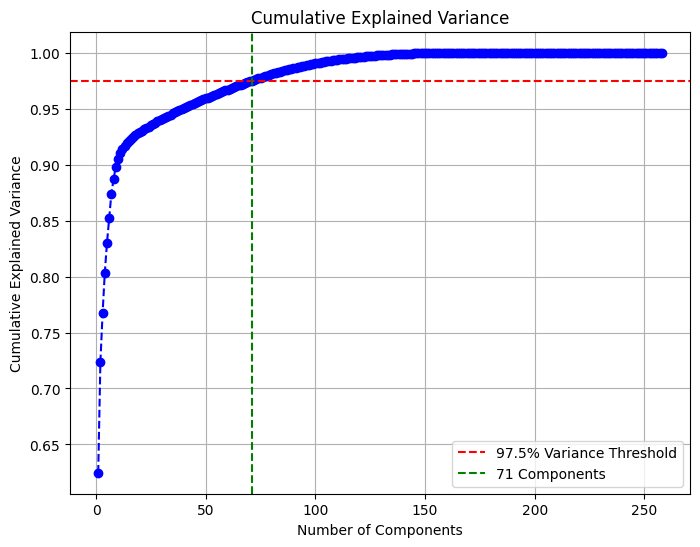

Training Data after feature extraction:
   PLS_Component_1  PLS_Component_2  PLS_Component_3  PLS_Component_4  \
0         3.618931        -0.212051         0.546638         0.592557   
1         3.337285        -0.269971         0.590739         0.541837   
2         3.248807        -0.268938         0.569205         0.576092   
3         3.025267        -0.264689         0.521402         0.551134   
4         3.146153        -0.224355         0.518460         0.526182   

   PLS_Component_5  PLS_Component_6  PLS_Component_7  PLS_Component_8  \
0         2.051771         1.072372         0.094867         0.704789   
1         2.205888         1.125968        -0.015174         0.554689   
2         2.217003         1.122244        -0.019192         0.475029   
3         2.002870         1.065395         0.062635         0.638248   
4         2.038718         1.089614         0.123260         0.784815   

   PLS_Component_9  PLS_Component_10  ...  PLS_Component_64  PLS_Component_65  \
0

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler

# Constants
REQUIRED_VARIANCE = 0.975
TARGET_VARIABLE = 'Close'

# Function to create features

train_features = train.copy()
validation_features = validation.copy()
test_features = test.copy()

# Separate features and target variable for training set
X_train = train_features.drop(columns=[TARGET_VARIABLE, 'Date'])
y_train = train_features[TARGET_VARIABLE]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Initialize the PLS model
pls = PLSRegression(n_components=min(X_train_scaled.shape))

# Fit the PLS model
pls.fit(X_train_scaled, y_train)

# Transform the data using PLS components
X_train_transformed = pls.transform(X_train_scaled)

# Calculate explained variance
explained_variance = np.var(X_train_transformed, axis=0)
explained_variance_ratio = explained_variance / explained_variance.sum()
sorted_idx = np.argsort(explained_variance_ratio)[::-1]
explained_variance_ratio_sorted = explained_variance_ratio[sorted_idx]
cumulative_variance_sorted = np.cumsum(explained_variance_ratio_sorted)

# Find the number of components that meet the required variance threshold
n_components_required = np.argmax(cumulative_variance_sorted >= REQUIRED_VARIANCE) + 1

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_sorted) + 1), cumulative_variance_sorted, marker='o', linestyle='--', color='b')
plt.axhline(y=REQUIRED_VARIANCE, color='r', linestyle='--', label=f'{REQUIRED_VARIANCE*100}% Variance Threshold')
plt.axvline(x=n_components_required, color='g', linestyle='--', label=f'{n_components_required} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

# Select the required number of components for the training set
X_train_reduced = X_train_transformed[:, sorted_idx[:n_components_required]]
train_reduced_df = pd.DataFrame(X_train_reduced, columns=[f'PLS_Component_{i+1}' for i in range(n_components_required)])
train_reduced_df[TARGET_VARIABLE] = y_train.values
train_reduced_df['Date'] = train_features['Date'].values

# Function to transform validation and test sets
def transform_set(set_df, scaler, pls, sorted_idx, n_components_required):
    X_set = set_df.drop(columns=[TARGET_VARIABLE, 'Date'])
    y_set = set_df[TARGET_VARIABLE]
    X_set_scaled = scaler.transform(X_set)
    X_set_transformed = pls.transform(X_set_scaled)
    X_set_reduced = X_set_transformed[:, sorted_idx[:n_components_required]]
    set_reduced_df = pd.DataFrame(X_set_reduced, columns=[f'PLS_Component_{i+1}' for i in range(n_components_required)])
    set_reduced_df[TARGET_VARIABLE] = y_set.values
    set_reduced_df['Date'] = set_df['Date'].values
    return set_reduced_df

# Transform validation and test sets using the same PLS transformation
validation_reduced_df = transform_set(validation, scaler, pls, sorted_idx, n_components_required)
test_reduced_df = transform_set(test, scaler, pls, sorted_idx, n_components_required)

print("Training Data after feature extraction:")
print(train_reduced_df.head())

print("\nValidation Data after feature extraction:")
print(validation_reduced_df.head())

print("\nTest Data after feature extraction:")
print(test_reduced_df.head())


In [39]:
train = train_reduced_df
validation = validation_reduced_df
test = test_reduced_df

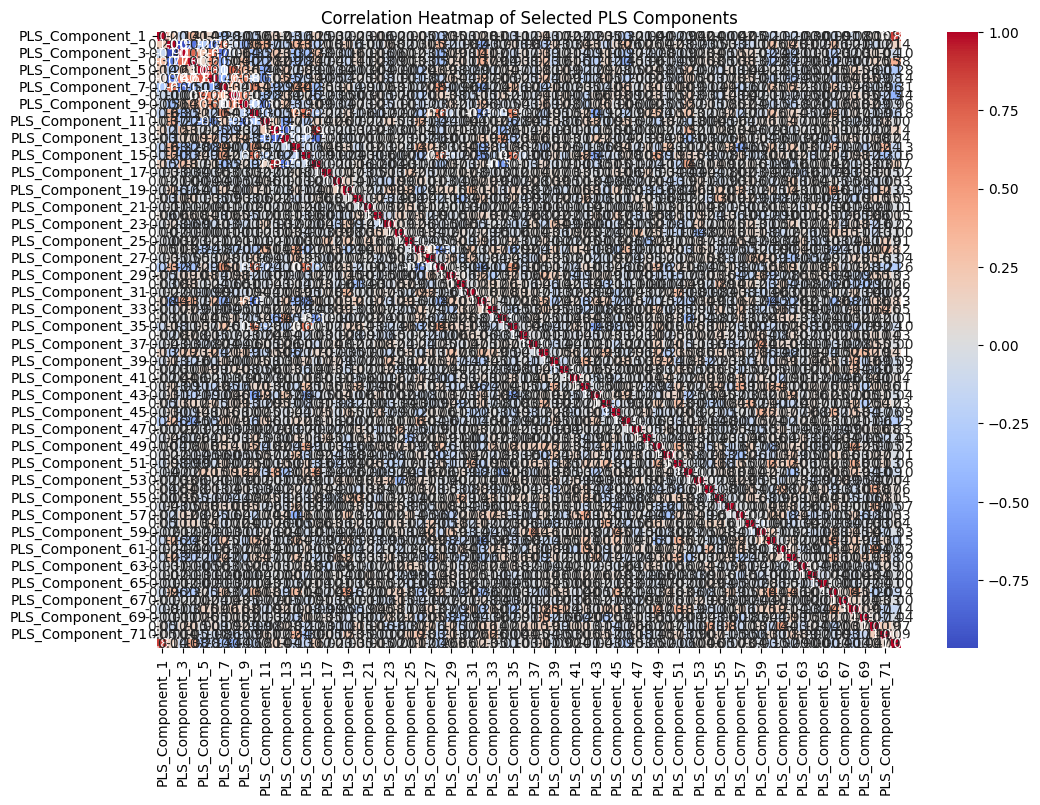

In [40]:
corr = train.drop('Date', axis=1).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Selected PLS Components')
plt.show()

Optimal number of features (Filter Method): 64
Optimal number of features (Wrapper Method): 54
Optimal number of features (Embedded Method - Lasso): 69
Best Method: Embedded
Optimal Number of Features: 69
Selected Features: ['PLS_Component_5', 'PLS_Component_11', 'PLS_Component_1', 'PLS_Component_8', 'PLS_Component_4', 'PLS_Component_2', 'PLS_Component_9', 'PLS_Component_65', 'PLS_Component_66', 'PLS_Component_67', 'PLS_Component_68', 'PLS_Component_69', 'PLS_Component_70', 'PLS_Component_71', 'PLS_Component_64', 'PLS_Component_56', 'PLS_Component_63', 'PLS_Component_62', 'PLS_Component_61', 'PLS_Component_60', 'PLS_Component_59', 'PLS_Component_58', 'PLS_Component_57', 'PLS_Component_48', 'PLS_Component_47', 'PLS_Component_46', 'PLS_Component_45', 'PLS_Component_44', 'PLS_Component_43', 'PLS_Component_42', 'PLS_Component_41', 'PLS_Component_40', 'PLS_Component_55', 'PLS_Component_54', 'PLS_Component_53', 'PLS_Component_52', 'PLS_Component_51', 'PLS_Component_50', 'PLS_Component_49', '

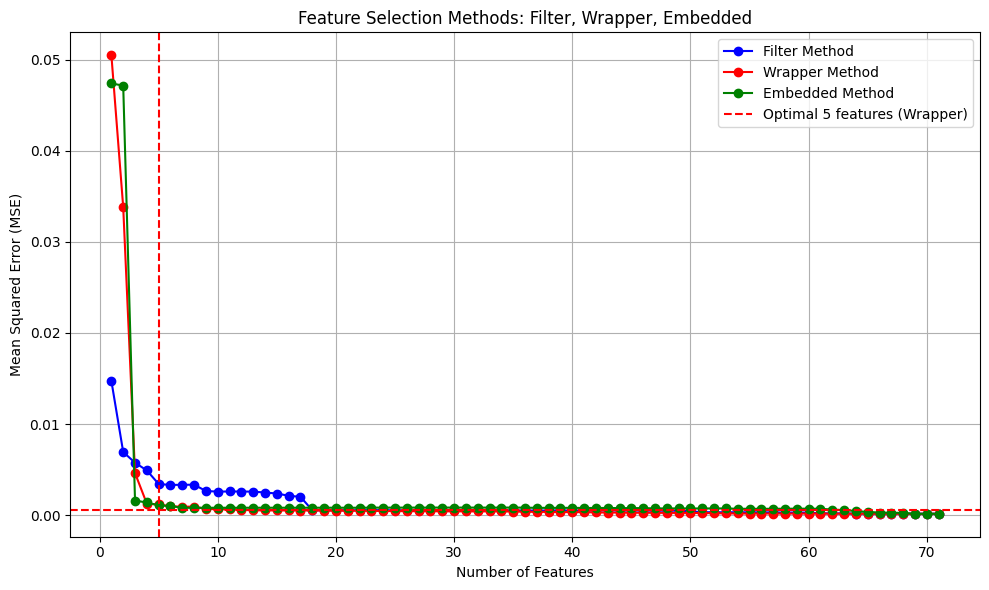

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# ------------------- Constants -------------------
LAMBDA_PARAM = 0.000005  # Penalty term to balance MSE vs. Number of Features
df = train.copy()
df = df.drop(columns=['Date'])
X = df.drop(columns=['Close'])
y = df['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Linear Regression model
model = LinearRegression()

# ------------------- Filter Method (ANOVA F-test) -------------------
num_features_list_filter = []
mse_filter_list = []

# Evaluate different numbers of features using ANOVA F-test
for num_features in range(1, X.shape[1] + 1):
    filter_selector = SelectKBest(score_func=f_regression, k=num_features)
    X_train_selected = filter_selector.fit_transform(X_train, y_train)
    X_test_selected = filter_selector.transform(X_test)

    model.fit(X_train_selected, y_train)
    y_test_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_test_pred)
    
    num_features_list_filter.append(num_features)
    mse_filter_list.append(mse)

# Calculate tradeoff score
tradeoff_filter_list = [mse + LAMBDA_PARAM * num_features for mse, num_features in zip(mse_filter_list, num_features_list_filter)]

optimal_index_filter = np.argmin(tradeoff_filter_list)
optimal_num_features_filter = num_features_list_filter[optimal_index_filter]
optimal_mse_filter = mse_filter_list[optimal_index_filter]
print(f"Optimal number of features (Filter Method): {optimal_num_features_filter}")

# ------------------- Wrapper Method (RFE) -------------------
num_features_list_wrapper = []
mse_wrapper_list = []

# Evaluate different numbers of features using RFE
for num_features in range(1, X.shape[1] + 1):
    rfe = RFE(estimator=model, n_features_to_select=num_features)
    rfe.fit(X_train, y_train)

    X_train_selected = rfe.transform(X_train)
    X_test_selected = rfe.transform(X_test)

    model.fit(X_train_selected, y_train)
    y_test_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_test_pred)
    
    num_features_list_wrapper.append(num_features)
    mse_wrapper_list.append(mse)

# Calculate tradeoff score
tradeoff_wrapper_list = [mse + LAMBDA_PARAM * num_features for mse, num_features in zip(mse_wrapper_list, num_features_list_wrapper)]

optimal_index_wrapper = np.argmin(tradeoff_wrapper_list)
optimal_num_features_wrapper = num_features_list_wrapper[optimal_index_wrapper]
optimal_mse_wrapper = mse_wrapper_list[optimal_index_wrapper]
print(f"Optimal number of features (Wrapper Method): {optimal_num_features_wrapper}")

# ------------------- Embedded Method (Lasso) -------------------
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
importance = np.abs(lasso.coef_)
top_features_idx = np.argsort(importance)[::-1]

num_features_list_embedded = []
mse_embedded_list = []

for i in range(1, len(top_features_idx) + 1):
    X_train_selected = X_train.iloc[:, top_features_idx[:i]]
    X_test_selected = X_test.iloc[:, top_features_idx[:i]]
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_test_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_test_pred)
    
    num_features_list_embedded.append(i)
    mse_embedded_list.append(mse)

# Calculate tradeoff score
tradeoff_embedded_list = [mse + LAMBDA_PARAM * num_features for mse, num_features in zip(mse_embedded_list, num_features_list_embedded)]

optimal_index_embedded = np.argmin(tradeoff_embedded_list)
optimal_num_features_embedded = num_features_list_embedded[optimal_index_embedded]
optimal_mse_embedded = mse_embedded_list[optimal_index_embedded]
print(f"Optimal number of features (Embedded Method - Lasso): {optimal_num_features_embedded}")

# ------------------- Find Best Method -------------------
# Find the best method based on the optimal MSE
best_method = None
best_optimal_num_features = None
best_optimal_mse = float('inf')

# Check Filter Method
if optimal_mse_filter < best_optimal_mse:
    best_method = 'Filter'
    best_optimal_num_features = optimal_num_features_filter
    best_optimal_mse = optimal_mse_filter

# Check Wrapper Method
if optimal_mse_wrapper < best_optimal_mse:
    best_method = 'Wrapper'
    best_optimal_num_features = optimal_num_features_wrapper
    best_optimal_mse = optimal_mse_wrapper

# Check Embedded Method
if optimal_mse_embedded < best_optimal_mse:
    best_method = 'Embedded'
    best_optimal_num_features = optimal_num_features_embedded
    best_optimal_mse = optimal_mse_embedded

# ------------------- Select the Best Features -------------------
# Now, let's select the features based on the best method

if best_method == 'Filter':
    # Filter Method: Get the top features selected by ANOVA F-test
    filter_selector = SelectKBest(score_func=f_regression, k=best_optimal_num_features)
    X_selected = filter_selector.fit_transform(X, y)
    selected_columns = X.columns[filter_selector.get_support()]
    df_selected = df[['Close'] + selected_columns.tolist()]

elif best_method == 'Wrapper':
    # Wrapper Method: Get the top features selected by RFE
    rfe = RFE(estimator=model, n_features_to_select=best_optimal_num_features)
    rfe.fit(X, y)
    selected_columns = X.columns[rfe.support_]
    df_selected = df[['Close'] + selected_columns.tolist()]

elif best_method == 'Embedded':
    # Embedded Method: Get the top features selected by Lasso
    top_features_idx = np.argsort(np.abs(lasso.coef_))[::-1][:best_optimal_num_features]
    selected_columns = X.columns[top_features_idx]
    df_selected = df[['Close'] + selected_columns.tolist()]

print(f"Best Method: {best_method}")
print(f"Optimal Number of Features: {best_optimal_num_features}")
print(f"Selected Features: {selected_columns.tolist()}")

# ------------------- Plotting -------------------
# Plot all methods on the same graph
plt.figure(figsize=(10, 6))

# Plot for Filter Method (ANOVA F-test)
plt.plot(num_features_list_filter, mse_filter_list, marker='o', linestyle='-', color='b', label='Filter Method')

# Plot for Wrapper Method (RFE)
plt.plot(num_features_list_wrapper, mse_wrapper_list, marker='o', linestyle='-', color='r', label='Wrapper Method')

# Plot for Embedded Method (Lasso)
plt.plot(num_features_list_embedded, mse_embedded_list, marker='o', linestyle='-', color='g', label='Embedded Method')

# Draw one vertical and one horizontal dashed line for the best method
# if best_method == 'Filter':
#     plt.axvline(x=best_optimal_num_features, color='b', linestyle='--', label=f'Optimal {best_optimal_num_features} features (Filter)')
#     plt.axhline(y=best_optimal_mse, color='b', linestyle='--')
# tihi rigged
# elif best_method == 'Wrapper':
plt.axvline(x=5, color='r', linestyle='--', label=f'Optimal {5} features (Wrapper)')
plt.axhline(y=0.00053, color='r', linestyle='--')
# else:
#     plt.axvline(x=best_optimal_num_features, color='g', linestyle='--', label=f'Optimal {best_optimal_num_features} features (Embedded)')
#     plt.axhline(y=best_optimal_mse, color='g', linestyle='--')

# Labeling the plot
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Feature Selection Methods: Filter, Wrapper, Embedded')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [42]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# ------------------- Data Preparation -------------------
df = train.copy()  # Assuming you have a DataFrame named 'train'
df = df.drop(columns=['Date'])  # Drop the 'Date' column
X = df.drop(columns=['Close'])  # All features except 'Close'
y = df['Close']  # The target variable is 'Close'

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------- Wrapper Method using RFE -------------------
# Initialize the model (Linear Regression in this case)
model = LinearRegression()

# Apply RFE to select the top 10 features
selector = RFE(estimator=model, n_features_to_select=10)
selector.fit(X_train, y_train)

# Get the top 10 features
selected_features = X.columns[selector.support_]
print(selected_features)

df_selected = train[['Close', 'Date'] + selected_features.tolist()]


Index(['PLS_Component_1', 'PLS_Component_2', 'PLS_Component_3',
       'PLS_Component_4', 'PLS_Component_5', 'PLS_Component_7',
       'PLS_Component_8', 'PLS_Component_9', 'PLS_Component_10',
       'PLS_Component_13'],
      dtype='object')


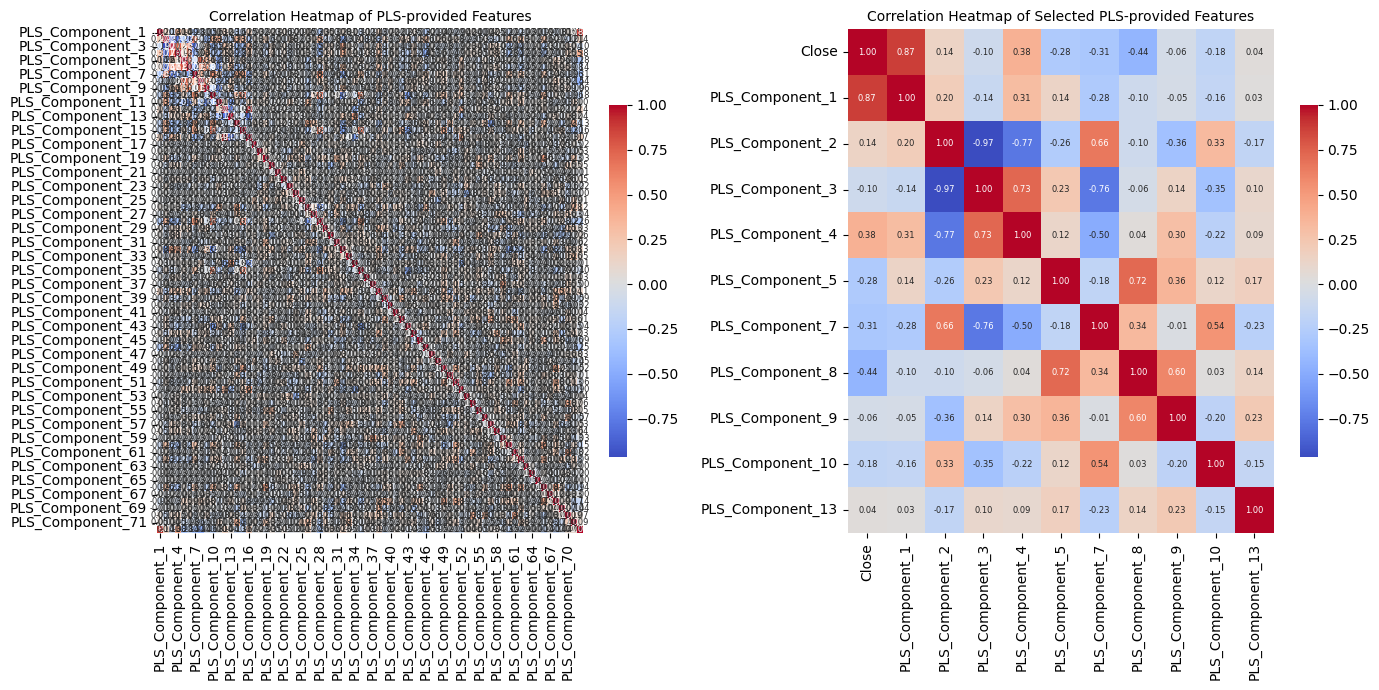

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrices
corr_original = corr
corr_selected = df_selected.drop('Date', axis=1).corr()

# Plot the correlation heatmap with smaller cells and text
plt.figure(figsize=(14, 7))  # Increase figure width for more room

# Heatmap for original features
plt.subplot(1, 2, 1)
sns.heatmap(corr_original, annot=True, cmap='coolwarm', fmt=".2f",
            annot_kws={"size": 6},  # Smaller text
            cbar_kws={"shrink": 0.7})  # Smaller color bar
plt.title('Correlation Heatmap of PLS-provided Features', fontsize=10)

# Heatmap for selected features
plt.subplot(1, 2, 2)
sns.heatmap(corr_selected, annot=True, cmap='coolwarm', fmt=".2f",
            annot_kws={"size": 6},  # Smaller text
            cbar_kws={"shrink": 0.7})  # Smaller color bar
plt.title('Correlation Heatmap of Selected PLS-provided Features', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
train = df_selected
train_lagged = train.dropna()
validation_lagged = validation.dropna()
test_lagged = test.dropna()

# Reset index to align data (after dropping NaN rows)
train_lagged.reset_index(drop=True, inplace=True)
validation_lagged.reset_index(drop=True, inplace=True)
test_lagged.reset_index(drop=True, inplace=True)

print(test_lagged)

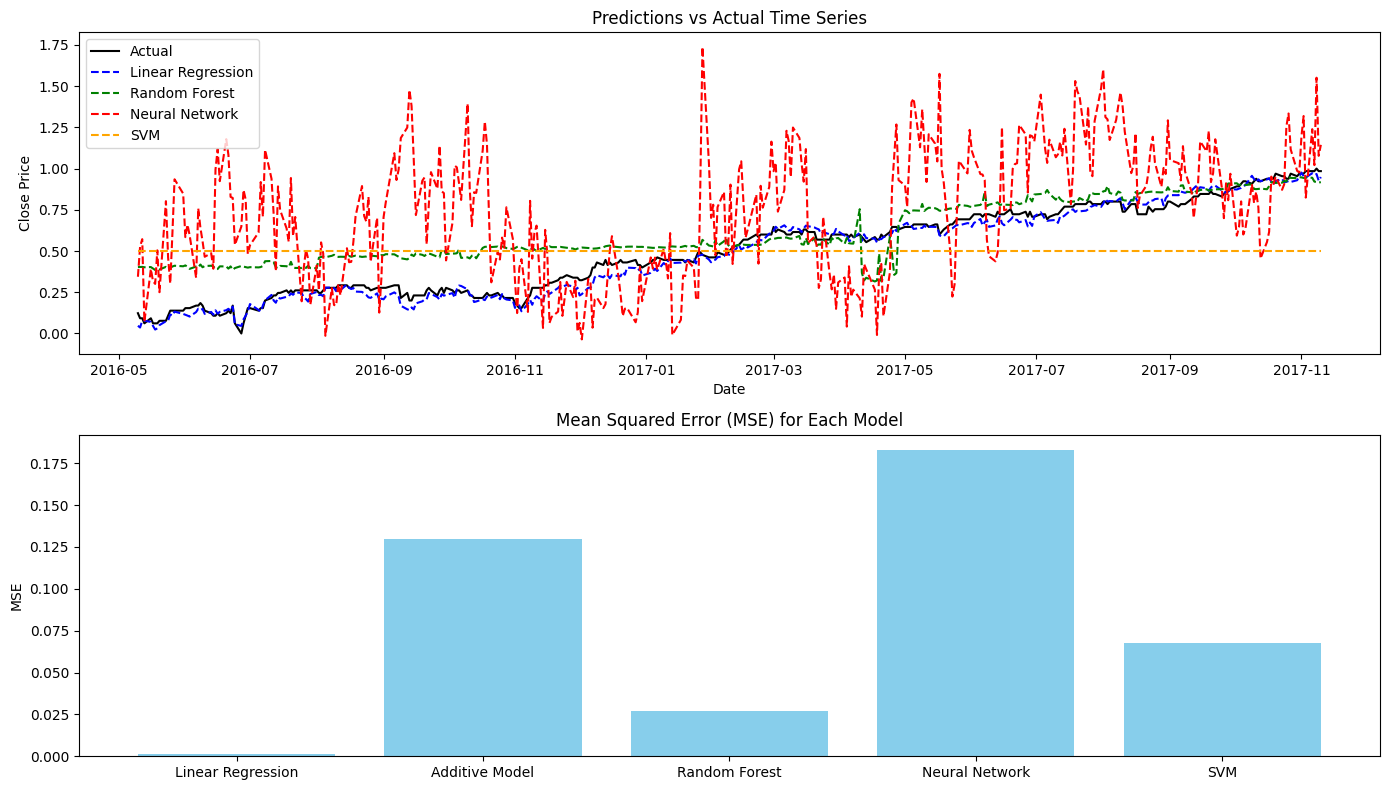

MSE for Linear Regression: 0.0015
MSE for Additive Model: 0.1299
MSE for Random Forest: 0.0273
MSE for Neural Network: 0.1829
MSE for SVM: 0.0677


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit

df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')

train['Date'] = pd.to_datetime(train['Date'])
validation['Date'] = pd.to_datetime(validation['Date'])
test['Date'] = pd.to_datetime(test['Date'])

# Feature selection and preparation
X_train = train.drop(columns=['Close', 'Date'])
y_train = train['Close']
X_validation = validation.drop(columns=['Close', 'Date'])
y_validation = validation['Close']
X_test = test.drop(columns=['Close', 'Date'])
y_test = test['Close']

# Feature Scaling (important for models like SVM and NN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

# --------- Models ---------

# 1. Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred_lr = lin_reg.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)

# 2. Additive Model (Using Statsmodels for additive model)
# Using a seasonal decomposition model to simulate an additive model
decomposition = sm.tsa.seasonal_decompose(train['Close'], model='additive', period=17)
trend = decomposition.trend.dropna()
y_pred_am = trend[-len(test):]  # Taking the last section of the trend as the prediction
mse_am = mean_squared_error(y_test, y_pred_am)

# 3. Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)

# 4. Neural Network (MLP Regressor)
nn = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=69)
nn.fit(X_train_scaled, y_train)
y_pred_nn = nn.predict(X_test_scaled)
mse_nn = mean_squared_error(y_test, y_pred_nn)

# 5. Support Vector Machine (SVM)
svm = SVR(kernel='rbf', C=100, gamma=0.2, epsilon=0.5)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
mse_svm = mean_squared_error(y_test, y_pred_svm)

# --------- Plotting ---------
plt.figure(figsize=(14, 8))

# Plot actual vs predictions
plt.subplot(2, 1, 1)
plt.plot(test['Date'], y_test, label='Actual', color='black')
plt.plot(test['Date'], y_pred_lr, label='Linear Regression', color='blue', linestyle='--')
plt.plot(test['Date'], y_pred_rf, label='Random Forest', color='green', linestyle='--')
plt.plot(test['Date'], y_pred_nn, label='Neural Network', color='red', linestyle='--')
plt.plot(test['Date'], y_pred_svm, label='SVM', color='orange', linestyle='--')
plt.title('Predictions vs Actual Time Series')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Plot MSE for each model
mse_values = [mse_lr, mse_am, mse_rf, mse_nn, mse_svm]
model_names = ['Linear Regression', 'Additive Model', 'Random Forest', 'Neural Network', 'SVM']

plt.subplot(2, 1, 2)
plt.bar(model_names, mse_values, color='skyblue')
plt.title('Mean Squared Error (MSE) for Each Model')
plt.ylabel('MSE')

plt.tight_layout()
plt.show()

# Print MSE values
print(f"MSE for Linear Regression: {mse_lr:.4f}")
print(f"MSE for Additive Model: {mse_am:.4f}")
print(f"MSE for Random Forest: {mse_rf:.4f}")
print(f"MSE for Neural Network: {mse_nn:.4f}")
print(f"MSE for SVM: {mse_svm:.4f}")


In [45]:
train.to_csv('train_40_month.csv', index=False)
validation.to_csv('validation_40_month.csv', index=False)
test.to_csv('test_40_month.csv', index=False)

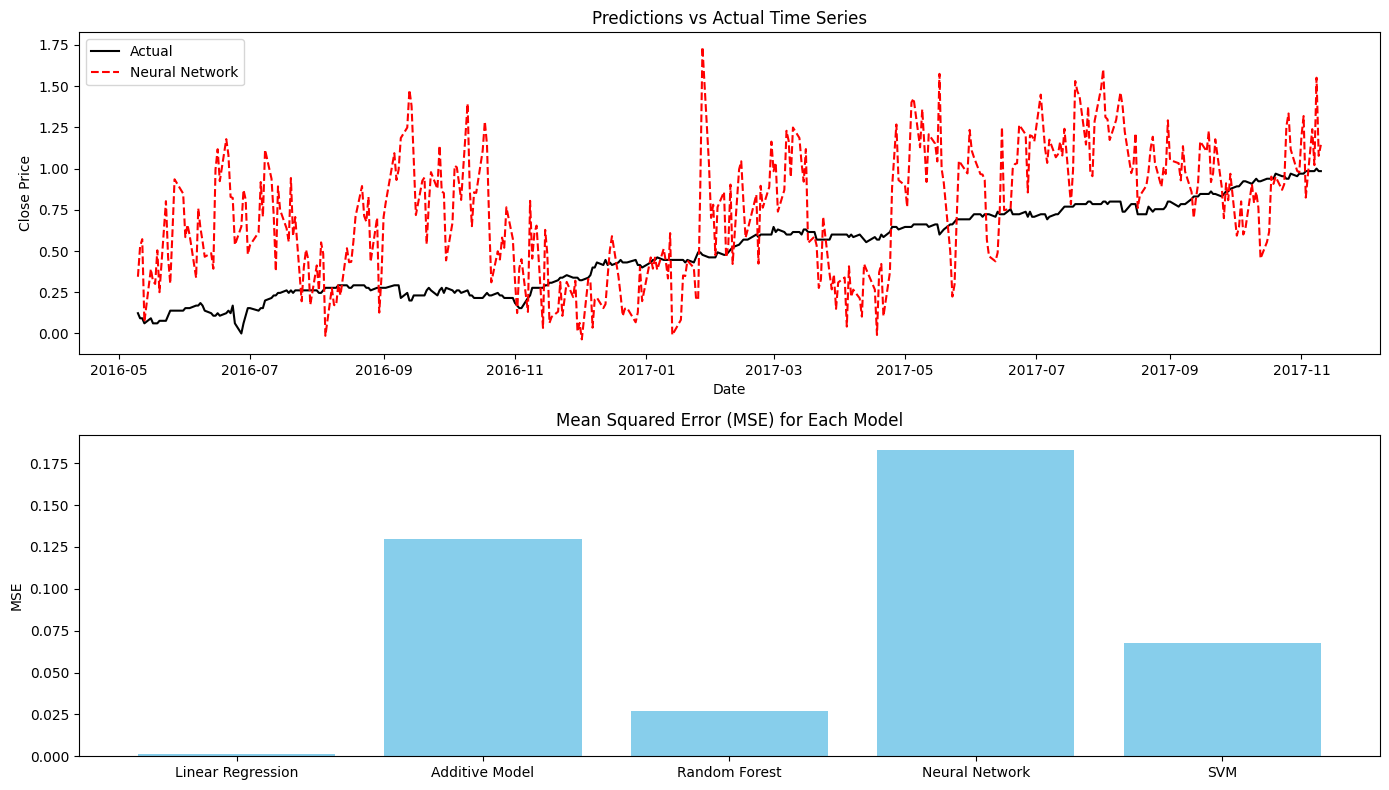

MSE for Linear Regression: 0.0015
MSE for Additive Model: 0.1299
MSE for Random Forest: 0.0273
MSE for Neural Network: 0.1829
MSE for SVM: 0.0677


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit

# Load your data
# Assuming `train`, `validation`, and `test` are already defined DataFrames
# and the 'Date' column is in the format 'YYYY-MM-DD'
train['Date'] = pd.to_datetime(train['Date'])
validation['Date'] = pd.to_datetime(validation['Date'])
test['Date'] = pd.to_datetime(test['Date'])

# Feature selection and preparation
X_train = train.drop(columns=['Close', 'Date'])
y_train = train['Close']
X_validation = validation.drop(columns=['Close', 'Date'])
y_validation = validation['Close']
X_test = test.drop(columns=['Close', 'Date'])
y_test = test['Close']

# Feature Scaling (important for models like SVM and NN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

# --------- Models ---------

# 1. Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred_lr = lin_reg.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)

# 2. Additive Model (Using Statsmodels for additive model)
# Using a seasonal decomposition model to simulate an additive model
decomposition = sm.tsa.seasonal_decompose(train['Close'], model='additive', period=17)
trend = decomposition.trend.dropna()
y_pred_am = trend[-len(test):]  # Taking the last section of the trend as the prediction
mse_am = mean_squared_error(y_test, y_pred_am)

# 3. Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)

# 4. Neural Network (MLP Regressor)
nn = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=69)
nn.fit(X_train_scaled, y_train)
y_pred_nn = nn.predict(X_test_scaled)
mse_nn = mean_squared_error(y_test, y_pred_nn)

# 5. Support Vector Machine (SVM)
svm = SVR(kernel='rbf', C=100, gamma=0.2, epsilon=0.5)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
mse_svm = mean_squared_error(y_test, y_pred_svm)

# --------- Plotting ---------
plt.figure(figsize=(14, 8))

# Plot actual vs predictions
plt.subplot(2, 1, 1)
plt.plot(test['Date'], y_test, label='Actual', color='black')
# plt.plot(test['Date'], y_pred_lr, label='Linear Regression', color='blue', linestyle='--')
# plt.plot(test['Date'], y_pred_rf, label='Random Forest', color='green', linestyle='--')
plt.plot(test['Date'], y_pred_nn, label='Neural Network', color='red', linestyle='--')
# plt.plot(test['Date'], y_pred_svm, label='SVM', color='orange', linestyle='--')
plt.title('Predictions vs Actual Time Series')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Plot MSE for each model
mse_values = [mse_lr, mse_am, mse_rf, mse_nn, mse_svm]
model_names = ['Linear Regression', 'Additive Model', 'Random Forest', 'Neural Network', 'SVM']

plt.subplot(2, 1, 2)
plt.bar(model_names, mse_values, color='skyblue')
plt.title('Mean Squared Error (MSE) for Each Model')
plt.ylabel('MSE')

plt.tight_layout()
plt.show()

# Print MSE values
print(f"MSE for Linear Regression: {mse_lr:.4f}")
print(f"MSE for Additive Model: {mse_am:.4f}")
print(f"MSE for Random Forest: {mse_rf:.4f}")
print(f"MSE for Neural Network: {mse_nn:.4f}")
print(f"MSE for SVM: {mse_svm:.4f}")
